In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import numpy as np
import warnings as wn
from xhistogram.xarray import histogram as xh
%reload_ext autoreload
%autoreload 2
import esm2m.myfunctions as func
from xhistogram.xarray import histogram as xh

In [3]:
wn.filterwarnings('ignore')
cod = pd.read_csv('species/atlantic_cod.csv', header=0)
bass = pd.read_csv('species/stripped_bass.csv', header=0)
flounder = pd.read_csv('species/summer_flounder.csv', header=0)
seabream = pd.read_csv('species/seabream.csv', header=0)
red_drum = pd.read_csv('species/red_drum.csv', header=0)
n_lampfish = pd.read_csv('species/northern_lampfish.csv', header=0)

In [4]:
rootdir = '/local/ss23/NEW_MI'
filename = 'MI_hitemp_sens_k01_ens*_1x1_1950_2100.nc'
path = rootdir+'/'+filename
z0_all = xr.open_mfdataset(path, engine='netcdf4', concat_dim='ensemble', combine='nested')
z0_avg = z0_all.mean(dim='ensemble')
z0Avg = xr.open_dataset('/home/aos/ystochel/esm2m/data/processed/MI_hitemp_sens_k01_ens130_1x1_1950_2100.nc')

In [5]:
rootdir = '/local/ss23/GFDL_LEs/'
experiment = 'OCN/METABOLIC_INDEX/RCP85'
filename = 'MI_hitemp_sens_k01_ens*_1x1_1950_2100.nc'
path = rootdir+experiment+'/'+filename
z0_all = xr.open_mfdataset(path, engine='netcdf4', concat_dim='ensemble', combine='nested')
z0_avg = z0_all.sel(ensemble=30)
z0_avg = z0_avg/2
z0_all = z0_all.sel(ensemble=slice(0,30))
z0_all = z0_all/2

In [6]:
rootdir = '/local/ss23/GFDL_LEs/'
subdir = 'AREA_FILES_ETC'
filename_area = 'WOA2001_grid.nc'
path_area = rootdir+subdir+'/'+filename_area
area = xr.open_dataset(path_area)['AREA'].rename({'latitude':'yt_ocean','longitude':'xt_ocean'})
area = area.assign_coords({'xt_ocean':z0_avg['xt_ocean'],'yt_ocean':z0_avg['yt_ocean']})
oceanmask = np.isfinite(z0_avg['MI'].isel(time=0).squeeze())
area_masked = area.where(oceanmask,np.nan)
ds_total = ~np.isnan(area.where(oceanmask))
total = ds_total.sum(dim='yt_ocean').sum(dim='xt_ocean')

# Method 1

In [6]:
hab = np.zeros((180,360),dtype=int)

In [12]:
coords = [-80.5,45.5,30.5,80.5]
col = np.arange(-80,46)
row = np.arange(30,81)

In [14]:
for x in col:
    for y in row:
        for i in range(18058):
            if cod['decimalLongitude'][i]>=x and cod['decimalLongitude'][i]<x+1 and cod['decimalLatitude'][i]>=y and cod['decimalLatitude'][i]<y+1:
                hab[y,x]=1

In [19]:
sum = np.sum(hab)

In [27]:
areaSum = hab*area_masked
areaSum = areaSum.sum(dim='xt_ocean').sum(dim='yt_ocean')

In [10]:
zeros = xr.zeros_like(z0_avg['MI'].isel(time=0))

In [17]:
z0_orig = ~np.isnan(zeros.where(zeros['xt_ocean']==cod['decimalLongitude'][0],drop=True))
z0_lat = ~np.isnan(z0_orig.where(z0_orig['yt_ocean']==cod['decimalLatitude'][0],drop=True))

In [19]:
z0_orig = zeros.where(zeros['xt_ocean']==cod['decimalLongitude'][0], 1)
z0_lat = z0_orig.where(zeros[])

# Method 2

In [7]:
def mi_dist(ds, mi, hab, area):
    red = ~np.isnan(ds.where(ds['MI']>mi))
    hab = hab.reindex_like(red, method='nearest', tolerance=0.01)
    thresh_red = hab*red
    redWhere = ~np.isnan(thresh_red.where(thresh_red['MI']!=0))
    redHab = (redWhere*area).sum(['xt_ocean','yt_ocean'])/(area.sum(['xt_ocean','yt_ocean']))
    redYear = redHab.groupby('time.year').mean().sel(year=slice(1990,2100))
    redPerc = (redYear['MI']/redYear['MI'].sel(year=1990))*100
    redEns = redPerc.mean(dim='ensemble')
    return redEns

In [8]:
def species(df_species):
    ds_cod = df_species.to_xarray()
    lon_bins = np.arange(-180,181)
    lat_bins = np.arange(-90,91)
    species_dist = xh(ds_cod['decimalLatitude'], ds_cod['decimalLongitude'],bins=[lat_bins, lon_bins])
    ds_hab = species_dist.where(species_dist<=1,1).rename({'decimalLongitude_bin':'xt_ocean','decimalLatitude_bin':'yt_ocean'})
    ds_hab = ds_hab.to_dataset().rename({'histogram_decimalLatitude_decimalLongitude':'MI'})
    return ds_hab

In [9]:
def plot_dist(red, orange, yel, gr, pur, species):
    fig, ax = plt.subplots(figsize=(10,8))
    wn.filterwarnings('ignore')
    fig.suptitle('RCP8.5 Ensemble Average, '+species+' Distribution, Z=0m (original data/2)')
    ax.plot(np.unique(red['year']),red,color='red',label='MI > 1')
    ax.plot(np.unique(orange['year']),orange,color='orange',label='MI > 2')
    ax.plot(np.unique(yel['year']),yel,color='yellow',label='MI > 3')
    ax.plot(np.unique(gr['year']),gr,color='green',label='MI > 4')
    ax.plot(np.unique(pur['year']),pur,color='purple',label='MI > 5')
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('Percent of 1990 habitat')
    # orPerc['MI'].sel(year=slice(1990,2100)).plot()

# Atlantic Cod

#### E0 = 0.42, A0 = 15.6, MI-crit = 2.1-2.2

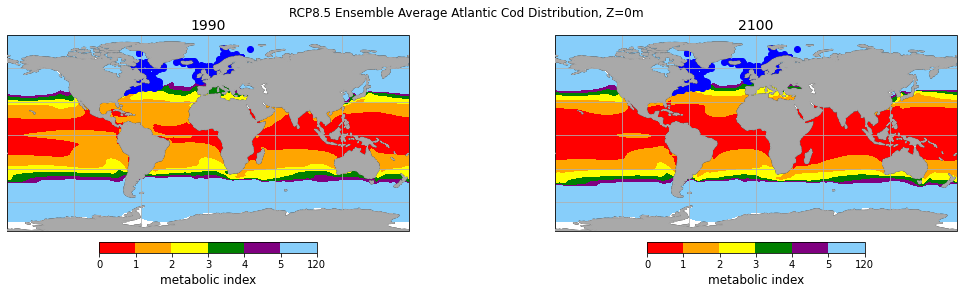

In [18]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, (ax0,ax1) = plt.subplots(figsize=(18,4),nrows=1,ncols=2,subplot_kw={'projection':crs})
fig.suptitle('RCP8.5 Ensemble Average Atlantic Cod Distribution, Z=0m')
func.graph(z0_avg, ax0, '1990', 1990, None, False)
ax0.scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')
func.graph(z0Avg, ax1, '2100', 2100, None, False)
ax1.scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')

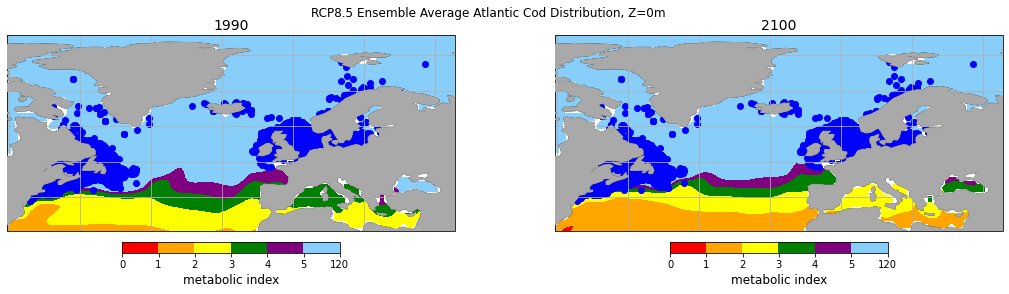

In [19]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, (ax0,ax1) = plt.subplots(figsize=(18,4),nrows=1,ncols=2,subplot_kw={'projection':crs})
coords = [-80.5,45.5,30.5,80.5]
fig.suptitle('RCP8.5 Ensemble Average Atlantic Cod Distribution, Z=0m')
func.graph(z0_avg, ax0, '1990', 1990, coords, False)
ax0.scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')
func.graph(z0_avg, ax1, '2100', 2100, coords, False)
ax1.scatter(cod['decimalLongitude'], cod['decimalLatitude'],color='blue')

In [37]:
cod_hab = species(cod)
red_cod = mi_dist(z0_all, 1.0, cod_hab, area_masked)
or_cod = mi_dist(z0_all, 2.0, cod_hab, area_masked)
yel_cod = mi_dist(z0_all, 3.0, cod_hab, area_masked)
gr_cod = mi_dist(z0_all, 4.0, cod_hab, area_masked)
pur_cod = mi_dist(z0_all, 5.0, cod_hab, area_masked)

Text(0, 0.5, 'Percent of 1990 habitat')

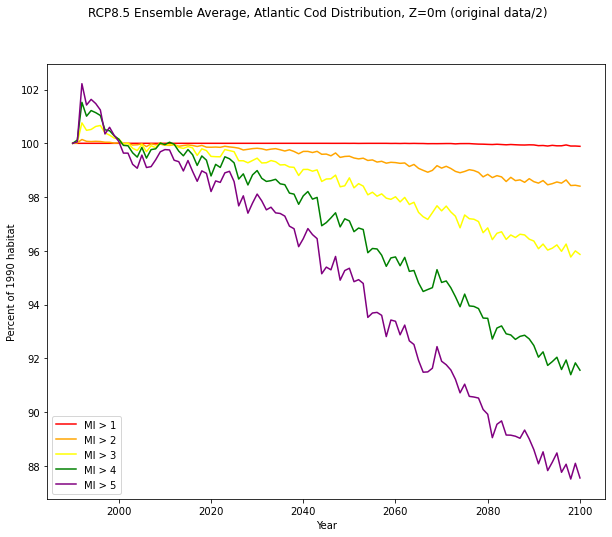

In [258]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Ensemble Average, Atlantic Cod Distribution, Z=0m (original data/2)')
ax.plot(np.unique(red_cod['year']),red_cod,color='red',label='MI > 1')
ax.plot(np.unique(or_cod['year']),or_cod,color='orange',label='MI > 2')
ax.plot(np.unique(yel_cod['year']),yel_cod,color='yellow',label='MI > 3')
ax.plot(np.unique(gr_cod['year']),gr_cod,color='green',label='MI > 4')
ax.plot(np.unique(pur_cod['year']),pur_cod,color='purple',label='MI > 5')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 habitat')
# orPerc['MI'].sel(year=slice(1990,2100)).plot()

Text(0, 0.5, 'Percent of 1990 habitat')

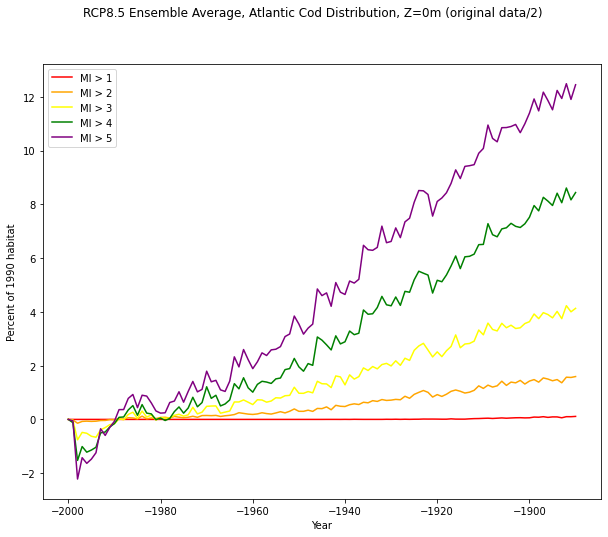

In [257]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Ensemble Average, Atlantic Cod Distribution, Z=0m (original data/2)')
ax.plot(np.unique(100-red_cod['year']),100-red_cod,color='red',label='MI > 1')
ax.plot(np.unique(100-or_cod['year']),100-or_cod,color='orange',label='MI > 2')
ax.plot(np.unique(100-yel_cod['year']),100-yel_cod,color='yellow',label='MI > 3')
ax.plot(np.unique(100-gr_cod['year']),100-gr_cod,color='green',label='MI > 4')
ax.plot(np.unique(100-pur_cod['year']),100-pur_cod,color='purple',label='MI > 5')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 habitat')
# orPerc['MI'].sel(year=slice(1990,2100)).plot()

Text(0, 0.5, 'Percent of 1990 habitat')

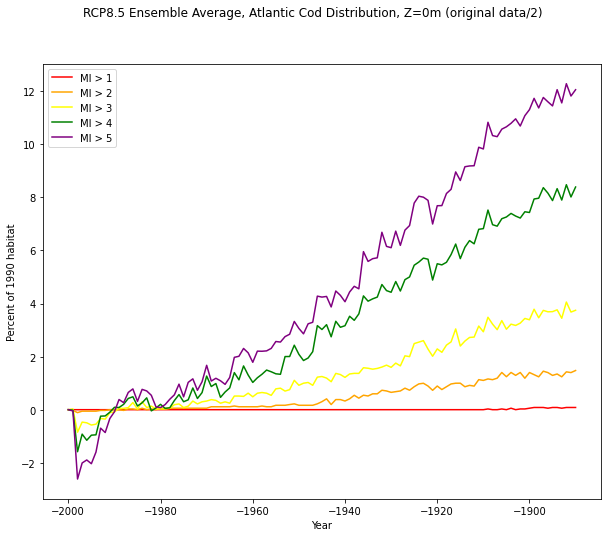

In [251]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Ensemble Average, Atlantic Cod Distribution, Z=0m (original data/2)')
ax.plot(np.unique(100-redPerc['year']),100-redPerc,color='red',label='MI > 1')
ax.plot(np.unique(100-orPerc['year']),100-orPerc,color='orange',label='MI > 2')
ax.plot(np.unique(100-yelPerc['year']),100-yelPerc,color='yellow',label='MI > 3')
ax.plot(np.unique(100-grPerc['year']),100-grPerc,color='green',label='MI > 4')
ax.plot(np.unique(100-purPerc['year']),100-purPerc,color='purple',label='MI > 5')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 habitat')
# orPerc['MI'].sel(year=slice(1990,2100)).plot()

Text(0, 0.5, 'Percent of 1990 habitat')

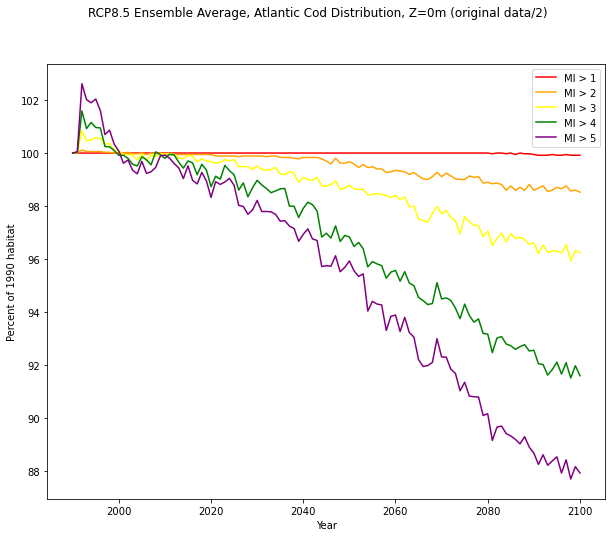

In [252]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Ensemble Average, Atlantic Cod Distribution, Z=0m (original data/2)')
ax.plot(np.unique(redPerc['year']),redPerc,color='red',label='MI > 1')
ax.plot(np.unique(orPerc['year']),orPerc,color='orange',label='MI > 2')
ax.plot(np.unique(yelPerc['year']),yelPerc,color='yellow',label='MI > 3')
ax.plot(np.unique(grPerc['year']),grPerc,color='green',label='MI > 4')
ax.plot(np.unique(purPerc['year']),purPerc,color='purple',label='MI > 5')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 habitat')
# orPerc['MI'].sel(year=slice(1990,2100)).plot()

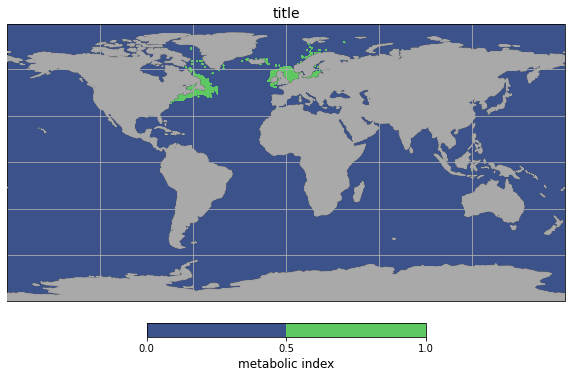

In [167]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(10,8),subplot_kw={'projection':crs})
clevs = np.array([0,0.5,1])
colorange = ['blue','lightskyblue']
crs = ccrs.PlateCarree()
X = thresh_pur['xt_ocean']
Y = thresh_pur['yt_ocean']
Z = thresh_pur['MI'].sel(time='1990-01-16').squeeze()
Z, X = add_cyclic_point(Z,coord=X)
im = ax.contourf(X,Y,Z,clevs,color=colorange,transform=crs)

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.gridlines()
ax.coastlines()
ax.set_title('title',fontsize=14,loc='center')

cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05,shrink=0.5)
cbar.set_label('metabolic index',fontsize=12)

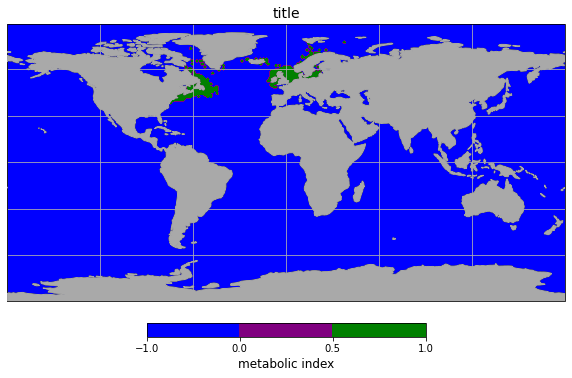

In [198]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(10,8),subplot_kw={'projection':crs})
# clevs = np.arange(0,1.1,0.6)
clevs = np.array([-1,0,0.5,1])
colorange = ['blue','purple','green']
n = 11
colorseq = pl.cm.cividis(np.linspace(0,1,n))
crs = ccrs.PlateCarree()
X = threshWhere['xt_ocean']
Y = threshWhere['yt_ocean']
Z = threshWhere['MI'].sel(time='2100-01-16').squeeze()
Z, X = add_cyclic_point(Z,coord=X)
im = ax.contourf(X,Y,Z,clevs,colors=colorange,transform=crs)

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.gridlines()
ax.coastlines()
ax.set_title('title',fontsize=14,loc='center')

cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05,shrink=0.5)
cbar.set_label('metabolic index',fontsize=12)

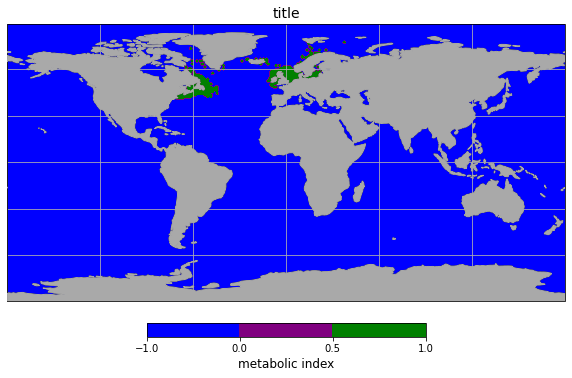

In [193]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(10,8),subplot_kw={'projection':crs})
# clevs = np.arange(0,1.1,0.6)
clevs = np.array([-1,0,0.5,1])
colorange = ['blue','purple','green']
n = 11
colorseq = pl.cm.cividis(np.linspace(0,1,n))
crs = ccrs.PlateCarree()
X = thresh_pur['xt_ocean']
Y = thresh_pur['yt_ocean']
Z = thresh_pur['MI'].sel(time='2100-01-16').squeeze()
Z, X = add_cyclic_point(Z,coord=X)
im = ax.contourf(X,Y,Z,clevs,colors=colorange,transform=crs)

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.gridlines()
ax.coastlines()
ax.set_title('title',fontsize=14,loc='center')

cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05,shrink=0.5)
cbar.set_label('metabolic index',fontsize=12)

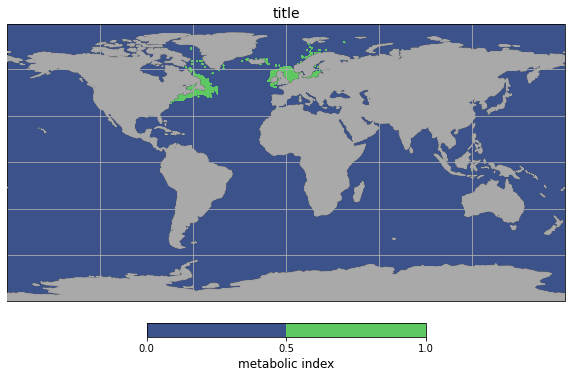

In [157]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(10,8),subplot_kw={'projection':crs})
clevs = np.array([0,0.5,1])
colorange = ['blue','lightskyblue']
crs = ccrs.PlateCarree()
X = thresh['xt_ocean']
Y = thresh['yt_ocean']
Z = thresh['MI'].sel(time='1990-01-16').squeeze()
Z, X = add_cyclic_point(Z,coord=X)
im = ax.contourf(X,Y,Z,clevs,color=colorange,transform=crs)

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.gridlines()
ax.coastlines()
ax.set_title('title',fontsize=14,loc='center')

cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05,shrink=0.5)
cbar.set_label('metabolic index',fontsize=12)

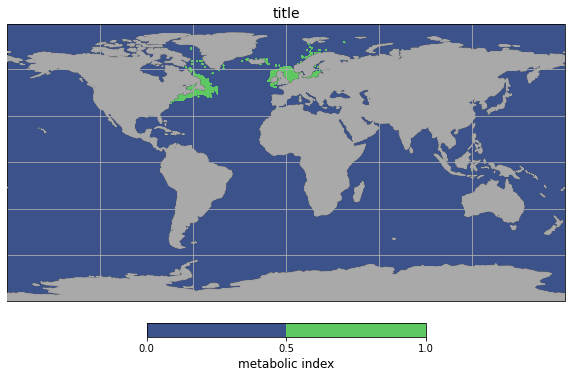

In [156]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(10,8),subplot_kw={'projection':crs})
clevs = np.array([0,0.5,1])
colorange = ['blue','lightskyblue']
crs = ccrs.PlateCarree()
X = thresh['xt_ocean']
Y = thresh['yt_ocean']
Z = thresh['MI'].sel(time='2100-01-16').squeeze()
Z, X = add_cyclic_point(Z,coord=X)
im = ax.contourf(X,Y,Z,clevs,color=colorange,transform=crs)

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.gridlines()
ax.coastlines()
ax.set_title('title',fontsize=14,loc='center')

cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05,shrink=0.5)
cbar.set_label('metabolic index',fontsize=12)

# Striped Bass

#### E0 = 0.33, A0 = 24, MI-crit = 4.8-5.0

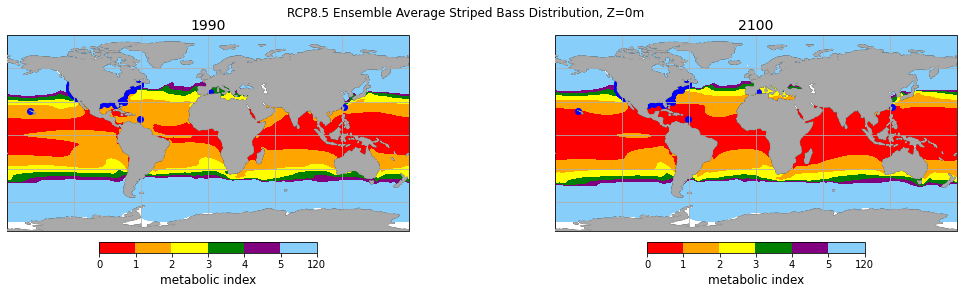

In [20]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, (ax0,ax1) = plt.subplots(figsize=(18,4),nrows=1,ncols=2,subplot_kw={'projection':crs})
fig.suptitle('RCP8.5 Ensemble Average Striped Bass Distribution, Z=0m')
func.graph(z0_avg, ax0, '1990', 1990, None, False)
ax0.scatter(bass['decimalLongitude'], bass['decimalLatitude'],color='blue')
func.graph(z0Avg, ax1, '2100', 2100, None, False)
ax1.scatter(bass['decimalLongitude'], bass['decimalLatitude'],color='blue')

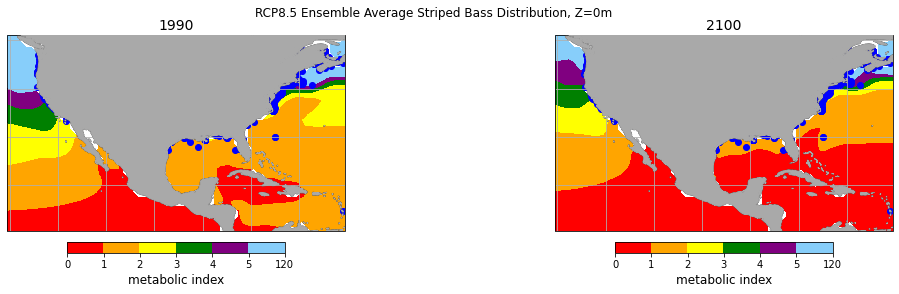

In [23]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, (ax0,ax1) = plt.subplots(figsize=(18,4),nrows=1,ncols=2,subplot_kw={'projection':crs})
coords = [-130.5,-60.5,10.5,45.5]
fig.suptitle('RCP8.5 Ensemble Average Striped Bass Distribution, Z=0m')
func.graph(z0_avg, ax0, '1990', 1990, coords, False)
ax0.scatter(bass['decimalLongitude'], bass['decimalLatitude'],color='blue')
func.graph(z0_avg, ax1, '2100', 2100, coords, False)
ax1.scatter(bass['decimalLongitude'], bass['decimalLatitude'],color='blue')

In [38]:
bass_hab = species(bass)
red_bass = mi_dist(z0_all, 1.0, bass_hab, area_masked)
or_bass = mi_dist(z0_all, 2.0, bass_hab, area_masked)
yel_bass = mi_dist(z0_all, 3.0, bass_hab, area_masked)
gr_bass = mi_dist(z0_all, 4.0, bass_hab, area_masked)
pur_bass = mi_dist(z0_all, 5.0, bass_hab, area_masked)

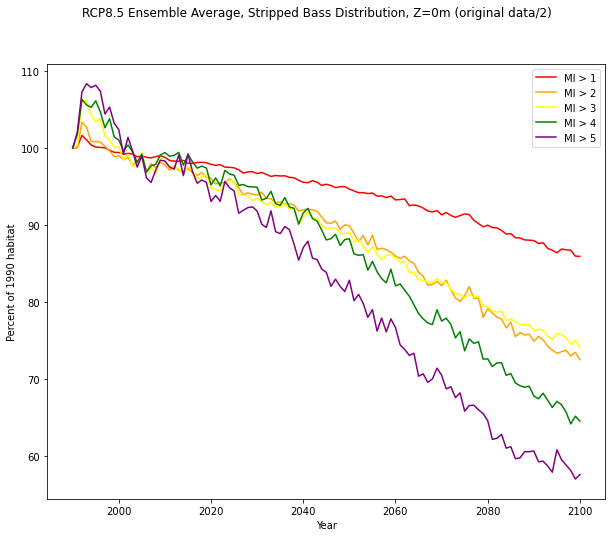

In [16]:
plot_dist(red_bass, or_bass, yel_bass, gr_bass, pur_bass, 'Stripped Bass')

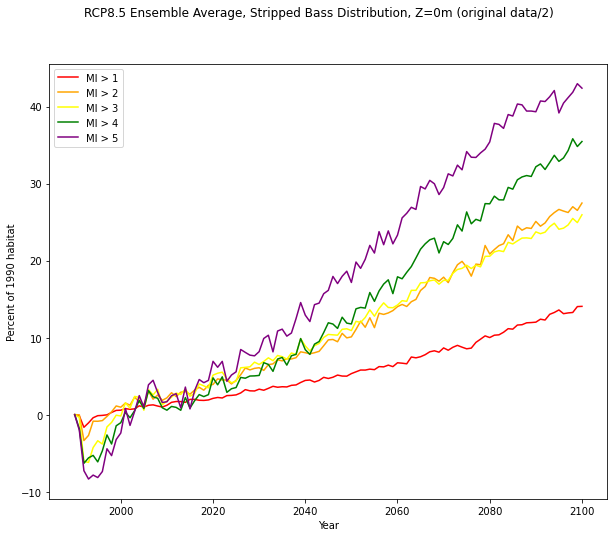

In [17]:
plot_dist(100-red_bass, 100-or_bass, 100-yel_bass, 100-gr_bass, 100-pur_bass, 'Stripped Bass')

# Summer Flounder

#### E0 = 0.35, A0 = 25.1, MI-crit = 3.5-3.6

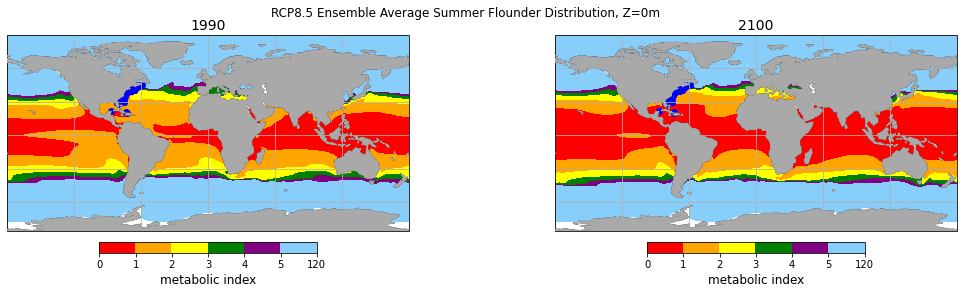

In [24]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, (ax0,ax1) = plt.subplots(figsize=(18,4),nrows=1,ncols=2,subplot_kw={'projection':crs})
fig.suptitle('RCP8.5 Ensemble Average Summer Flounder Distribution, Z=0m')
func.graph(z0_avg, ax0, '1990', 1990, None, False)
ax0.scatter(flounder['decimalLongitude'], flounder['decimalLatitude'],color='blue')
func.graph(z0Avg, ax1, '2100', 2100, None, False)
ax1.scatter(flounder['decimalLongitude'], flounder['decimalLatitude'],color='blue')

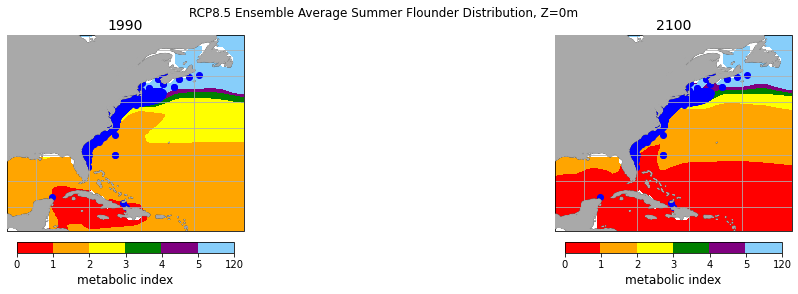

In [25]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, (ax0,ax1) = plt.subplots(figsize=(18,4),nrows=1,ncols=2,subplot_kw={'projection':crs})
coords = [-95.5,-50.5,15.5,50.5]
fig.suptitle('RCP8.5 Ensemble Average Summer Flounder Distribution, Z=0m')
func.graph(z0_avg, ax0, '1990', 1990, coords, False)
ax0.scatter(flounder['decimalLongitude'], flounder['decimalLatitude'],color='blue')
func.graph(z0_avg, ax1, '2100', 2100, coords, False)
ax1.scatter(flounder['decimalLongitude'], flounder['decimalLatitude'],color='blue')

In [39]:
flounder_hab = species(flounder)
red_flounder = mi_dist(z0_all, 1.0, flounder_hab, area_masked)
or_flounder = mi_dist(z0_all, 2.0, flounder_hab, area_masked)
yel_flounder = mi_dist(z0_all, 3.0, flounder_hab, area_masked)
gr_flounder = mi_dist(z0_all, 4.0, flounder_hab, area_masked)
pur_flounder = mi_dist(z0_all, 5.0, flounder_hab, area_masked)

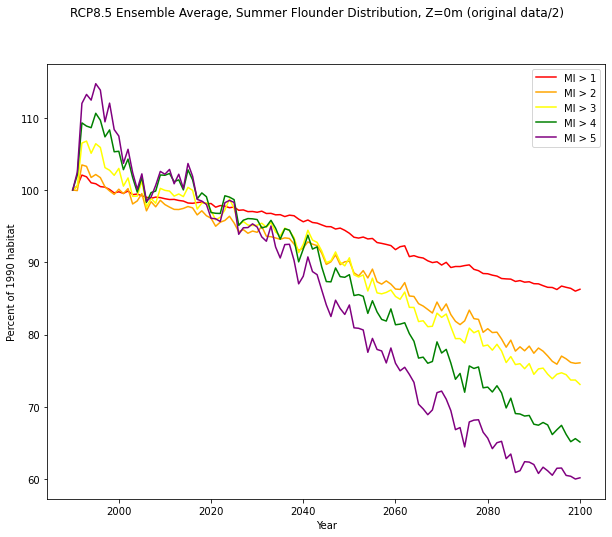

In [20]:
plot_dist(red_flounder, or_flounder, yel_flounder, gr_flounder, pur_flounder, 'Summer Flounder')

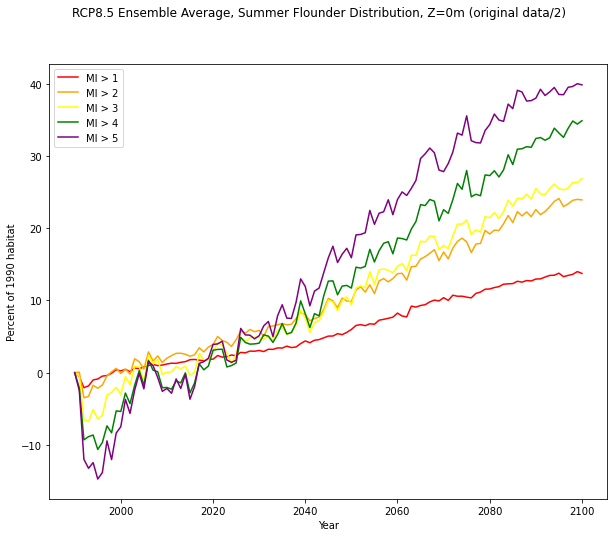

In [21]:
plot_dist(100-red_flounder, 100-or_flounder, 100-yel_flounder, 100-gr_flounder, 100-pur_flounder, 'Summer Flounder')

# Sharpsnout Seabream

#### E0 = 0.23, A0 = 53.9, MI-crit = 4.2

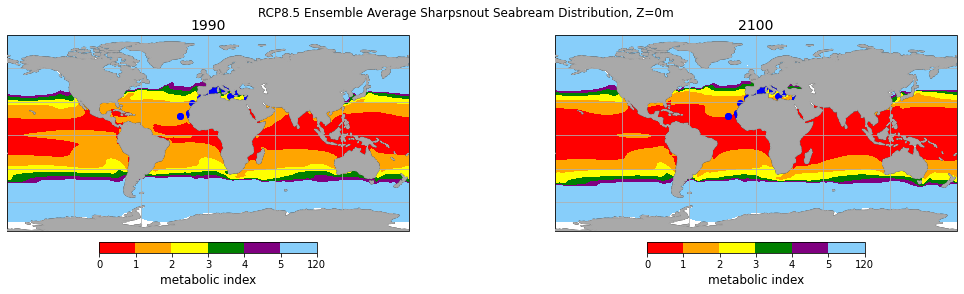

In [26]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, (ax0,ax1) = plt.subplots(figsize=(18,4),nrows=1,ncols=2,subplot_kw={'projection':crs})
fig.suptitle('RCP8.5 Ensemble Average Sharpsnout Seabream Distribution, Z=0m')
func.graph(z0_avg, ax0, '1990', 1990, None, False)
ax0.scatter(seabream['decimalLongitude'], seabream['decimalLatitude'],color='blue')
func.graph(z0Avg, ax1, '2100', 2100, None, False)
ax1.scatter(seabream['decimalLongitude'], seabream['decimalLatitude'],color='blue')

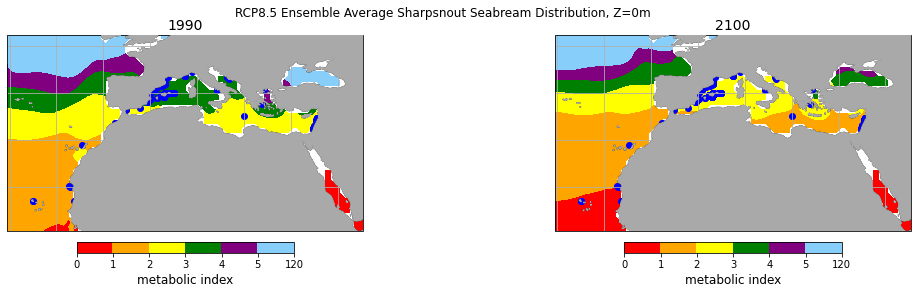

In [27]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, (ax0,ax1) = plt.subplots(figsize=(18,4),nrows=1,ncols=2,subplot_kw={'projection':crs})
coords = [-30.5,45.5,10.5,45.5]
fig.suptitle('RCP8.5 Ensemble Average Sharpsnout Seabream Distribution, Z=0m')
func.graph(z0_avg, ax0, '1990', 1990, coords, False)
ax0.scatter(seabream['decimalLongitude'], seabream['decimalLatitude'],color='blue')
func.graph(z0_avg, ax1, '2100', 2100, coords, False)
ax1.scatter(seabream['decimalLongitude'], seabream['decimalLatitude'],color='blue')

In [40]:
seabream_hab = species(seabream)
red_seabream = mi_dist(z0_all, 1.0, seabream_hab, area_masked)
or_seabream = mi_dist(z0_all, 2.0, seabream_hab, area_masked)
yel_seabream = mi_dist(z0_all, 3.0, seabream_hab, area_masked)
gr_seabream = mi_dist(z0_all, 4.0, seabream_hab, area_masked)
pur_seabream = mi_dist(z0_all, 5.0, seabream_hab, area_masked)

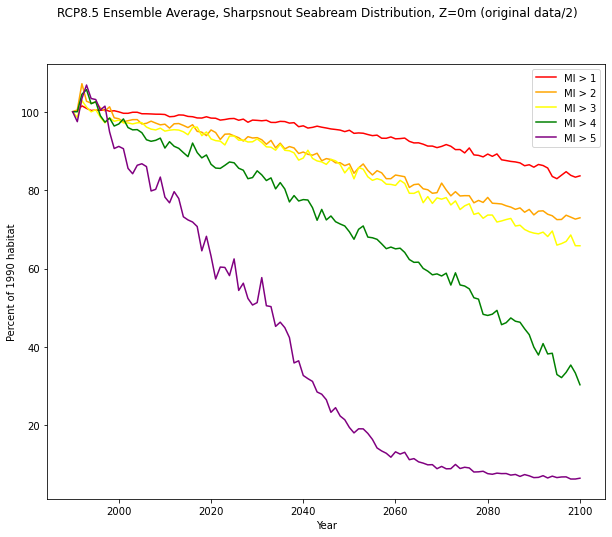

In [10]:
plot_dist(red_seabream, or_seabream, yel_seabream, gr_seabream, pur_seabream, 'Sharpsnout Seabream')

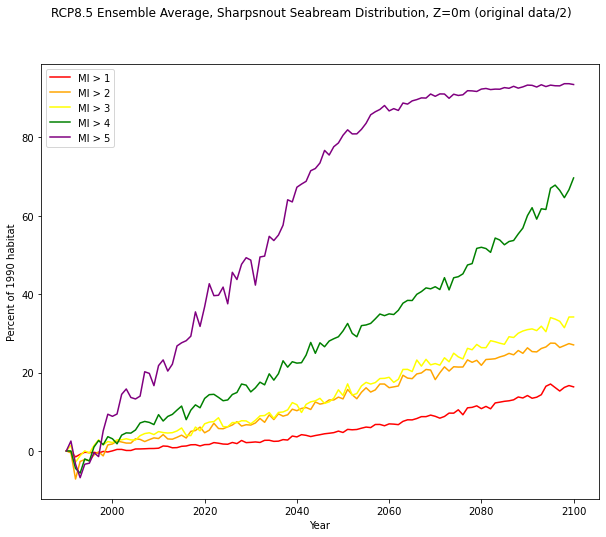

In [12]:
plot_dist(100-red_seabream, 100-or_seabream, 100-yel_seabream, 100-gr_seabream, 100-pur_seabream, 'Sharpsnout Seabream')

# Red Drum

#### E0 = 0.24, A0 = 32.3, MI-crit = 5.0-5.1

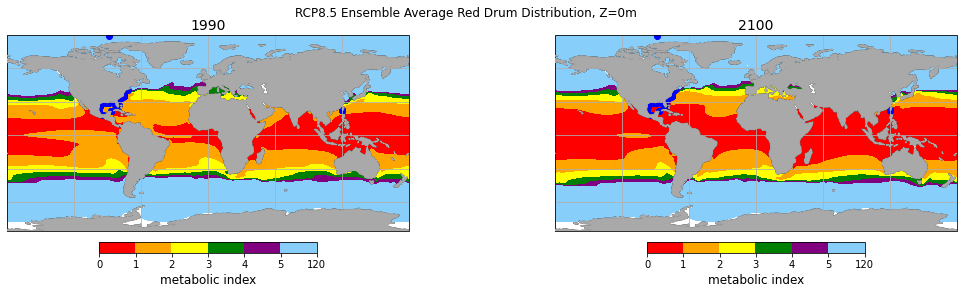

In [28]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, (ax0,ax1) = plt.subplots(figsize=(18,4),nrows=1,ncols=2,subplot_kw={'projection':crs})
fig.suptitle('RCP8.5 Ensemble Average Red Drum Distribution, Z=0m')
func.graph(z0_avg, ax0, '1990', 1990, None, False)
ax0.scatter(red_drum['decimalLongitude'], red_drum['decimalLatitude'],color='blue')
func.graph(z0Avg, ax1, '2100', 2100, None, False)
ax1.scatter(red_drum['decimalLongitude'], red_drum['decimalLatitude'],color='blue')

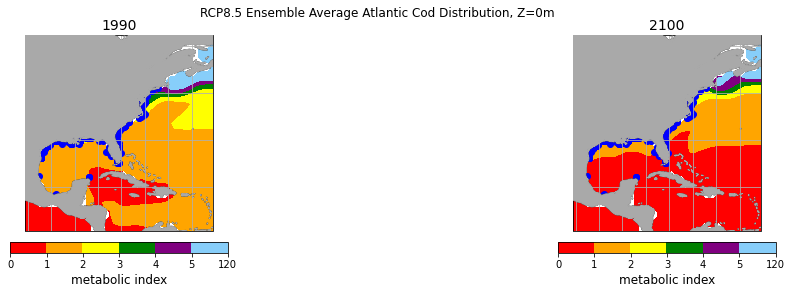

In [29]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, (ax0,ax1) = plt.subplots(figsize=(18,4),nrows=1,ncols=2,subplot_kw={'projection':crs})
coords = [-100.5,-60.5,10.5,50.5]
fig.suptitle('RCP8.5 Ensemble Average Atlantic Cod Distribution, Z=0m')
func.graph(z0_avg, ax0, '1990', 1990, coords, False)
ax0.scatter(red_drum['decimalLongitude'], red_drum['decimalLatitude'],color='blue')
func.graph(z0_avg, ax1, '2100', 2100, coords, False)
ax1.scatter(red_drum['decimalLongitude'], red_drum['decimalLatitude'],color='blue')

In [41]:
drum_hab = species(red_drum)
red_drum = mi_dist(z0_all, 1.0, drum_hab, area_masked)
or_drum = mi_dist(z0_all, 2.0, drum_hab, area_masked)
yel_drum = mi_dist(z0_all, 3.0, drum_hab, area_masked)
gr_drum = mi_dist(z0_all, 4.0, drum_hab, area_masked)
pur_drum = mi_dist(z0_all, 5.0, drum_hab, area_masked)

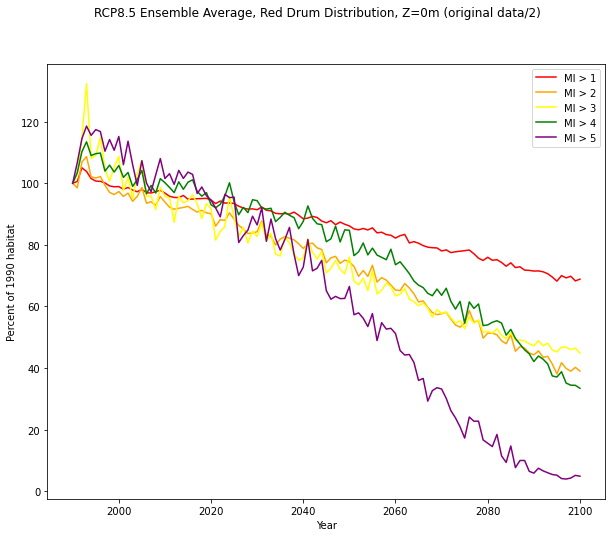

In [14]:
plot_dist(red_drum, or_drum, yel_drum, gr_drum, pur_drum, 'Red Drum')

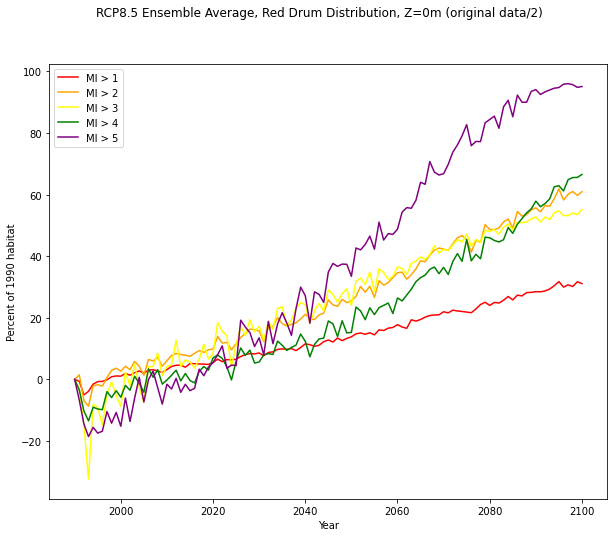

In [15]:
plot_dist(100-red_drum, 100-or_drum, 100-yel_drum, 100-gr_drum, 100-pur_drum, 'Red Drum')

# Northern Lampfish

#### E0 = 0.69, A0 = 23.4, MI-crit = 2.2-4.4

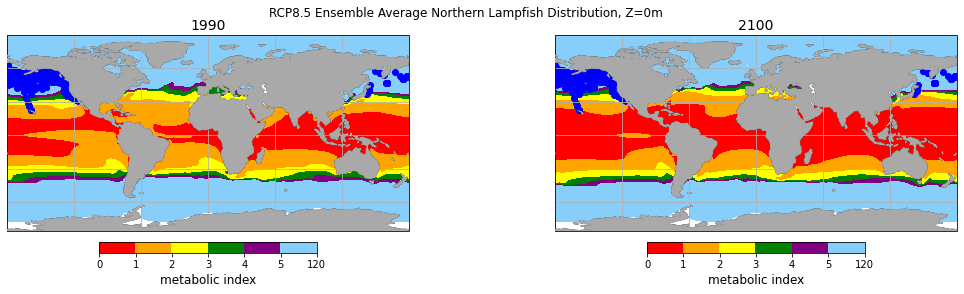

In [30]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, (ax0,ax1) = plt.subplots(figsize=(18,4),nrows=1,ncols=2,subplot_kw={'projection':crs})
fig.suptitle('RCP8.5 Ensemble Average Northern Lampfish Distribution, Z=0m')
func.graph(z0_avg, ax0, '1990', 1990, None, False)
ax0.scatter(n_lampfish['decimalLongitude'], n_lampfish['decimalLatitude'],color='blue')
func.graph(z0Avg, ax1, '2100', 2100, None, False)
ax1.scatter(n_lampfish['decimalLongitude'], n_lampfish['decimalLatitude'],color='blue')

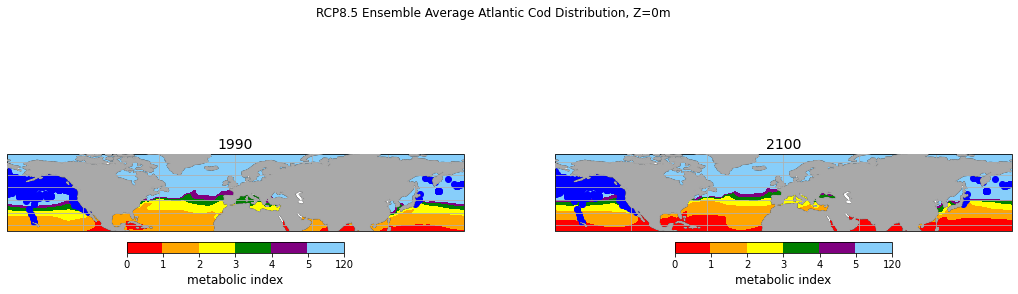

In [31]:
crs = ccrs.PlateCarree()
wn.filterwarnings('ignore')
fig, (ax0,ax1) = plt.subplots(figsize=(18,4),nrows=1,ncols=2,subplot_kw={'projection':crs})
coords = [135.5,-110.5,15.5,65.5]
fig.suptitle('RCP8.5 Ensemble Average Atlantic Cod Distribution, Z=0m')
func.graph(z0_avg, ax0, '1990', 1990, coords, False)
ax0.scatter(n_lampfish['decimalLongitude'], n_lampfish['decimalLatitude'],color='blue')
func.graph(z0_avg, ax1, '2100', 2100, coords, False)
ax1.scatter(n_lampfish['decimalLongitude'], n_lampfish['decimalLatitude'],color='blue')

In [42]:
lamp_hab = species(n_lampfish)
red_lamp = mi_dist(z0_all, 1.0, lamp_hab, area_masked)
or_lamp = mi_dist(z0_all, 2.0, lamp_hab, area_masked)
yel_lamp = mi_dist(z0_all, 3.0, lamp_hab, area_masked)
gr_lamp = mi_dist(z0_all, 4.0, lamp_hab, area_masked)
pur_lamp = mi_dist(z0_all, 5.0, lamp_hab, area_masked)

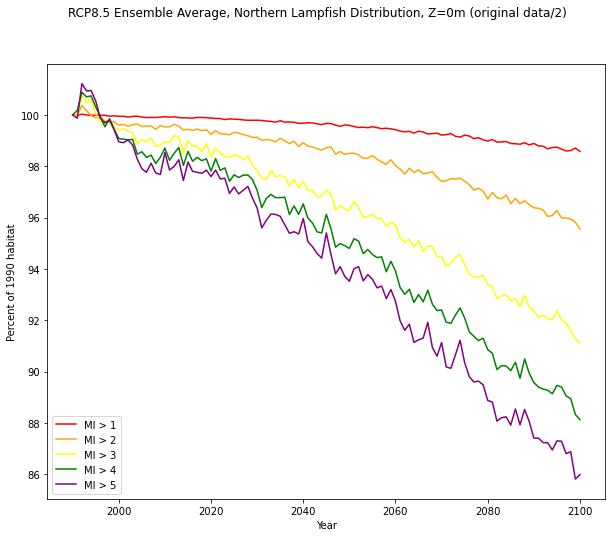

In [34]:
plot_dist(red_lamp, or_lamp, yel_lamp, gr_lamp, pur_lamp, 'Northern Lampfish')

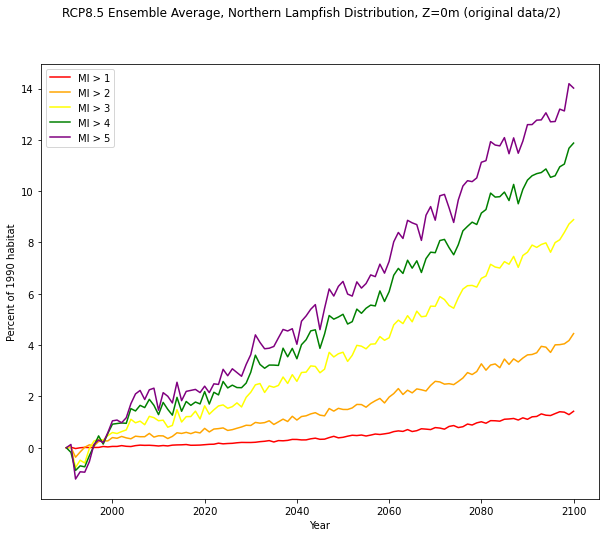

In [35]:
plot_dist(100-red_lamp, 100-or_lamp, 100-yel_lamp, 100-gr_lamp, 100-pur_lamp, 'Northern Lampfish')

# Summary

Text(0, 0.5, 'Percent of 1990 habitat')

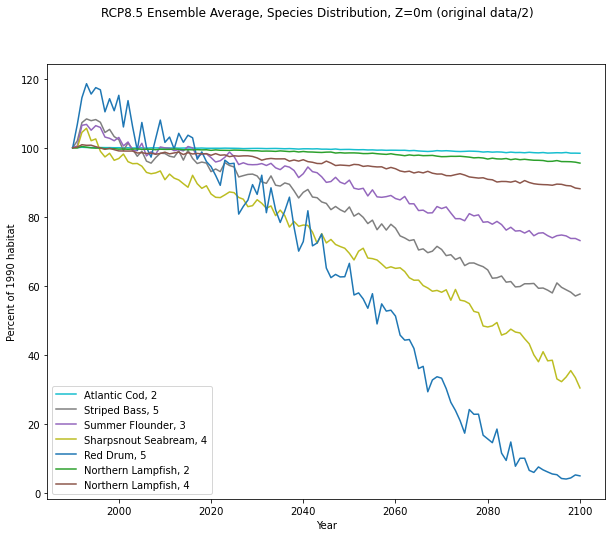

In [44]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Ensemble Average, Species Distribution, Z=0m (original data/2)')
ax.plot(np.unique(or_cod['year']),or_cod,color='tab:cyan',label='Atlantic Cod, 2')
ax.plot(np.unique(pur_bass['year']),pur_bass,color='tab:gray',label='Striped Bass, 5')
ax.plot(np.unique(yel_flounder['year']),yel_flounder,color='tab:purple',label='Summer Flounder, 3')
ax.plot(np.unique(gr_seabream['year']),gr_seabream,color='tab:olive',label='Sharpsnout Seabream, 4')
ax.plot(np.unique(pur_drum['year']),pur_drum,color='tab:blue',label='Red Drum, 5')
ax.plot(np.unique(or_lamp['year']),or_lamp,color='tab:green',label='Northern Lampfish, 2')
ax.plot(np.unique(gr_lamp['year']),gr_lamp,color='tab:brown',label='Northern Lampfish, 4')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 habitat')